# Data Generation Procedure
1. Make an outcome function of the covariates. This functional relationship is the same for all units.

Look into:
https://hazy.com/blog/2020/07/09/how-to-generate-sequential-data

For each unit:

2. Each covariate is a arma process with lag 1 and 0.9 correlation, moving average =1, with a random starting point in the range 10, 1000.
3. Once all covariates have been computed for all all time steps, the outcome for each timestep is computed by inputting the covariate values into the outcome function.
4. Append to the bottom of the dataset.

In [3]:
import statsmodels as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import pandas as pd
import random
import itertools
import string

class SimulateData(object):
    
    def __init__(self, n_donors, n_components, n_periods, treatment_period, treatment_effect=0):
        '''
        n_donors: int positive int. The number of potential control units, i.e. all units except the treated unit
        
        n_components: positive int. The number of covariates, or explanatory variables, in the dataset.
        The covariates columns are labeled "x0",...,"x(n-1)" if n_components=n
        These will the the right-most columns in the resulting dataset.
        
        n_periods: int >=2. The number of periods in which the outcome and covariates were observed.
        Equal to the maximum value in the "Time" column of the resulting dataset.
        
        treatment_period: int <n_periods. The first period in which the treated unit was exposed to the treatment.
        The treated unit is exposed to the treatment for every period in "Time" greater than or equal to treatment_period.
        
        treatment_effect: float. For each period after treatment_period, 
        the outcome of the treated unit is multiplied by (1+treatment_effect).
        Default=0.
        '''
        
        self.n_donors = n_donors
        self.n_components = n_components
        self.n_periods = n_periods
        
        assert treatment_period <= n_periods, "Treatment period must be 0< && <n_periods"
        self.treatment_period = treatment_period
        self.treatment_effect = treatment_effect

        self.coeffs = None #Stores coefficients of outcome function
        self.dataset = None #Stores dataset
        self.real_treatment_effect = None   #Array with value treatment_effect*treated_unit_outcome for every post-treatment period


    def make_component(self):
        '''
        Makes one covariate for one unit by adding an intercept, a linear trend and a sample from an arma model
        Values are arbitrary, but choosed to give positive series with trend and some noise
        Returns a list of length n_periods
        '''
        ar = np.r_[1, 0.9] #autoregressive component
        ma = np.array([100]) #moving-average component
        arma_process = ArmaProcess(ar, ma) #Define ARMA process
        arma_component = arma_process.generate_sample(nsample=self.n_periods) #Sample arma process
        
        additive_trend = np.random.normal(0, 300)
        trend = np.array([additive_trend*x for x in range(self.n_periods)])
        
        return random.randrange(10000, 10500) + np.add(arma_component, trend)
    
    def make_outcome_func(self, order):
        '''
        Chooses a subset of all possible terms of order<=order for n_components,
        Generates a random coefficient for each term, sampled from a lognormal(0, 25).
        Returns two 1-d arrays of equal size:
        terms with the indices of components that are to be multiplied
        coeffs with the coefficient by which the product of components will be weighted.
        
        order: Type:int. Gives the highest order terms that can be in the outcome function.
        For example, (x1, x1, x1) is a 3rd order term and (x1, x1) is a second order term.  
        Coefficients ~lognormal(0, 25) and divided by the order of the term to which they correspond
        '''
        
        #Record settings with which outcome func was created
        self.order = order
        
        #All first order terms are always included
        terms = list(range(self.n_components))
                
        #Generate list of all possible terms of 1< && <=self.order, given the number of components
        if self.order > 1:
            possible_terms = []
            for i in range(2, self.order+1):
                for term in itertools.combinations_with_replacement(list(range(self.n_components)), i):
                    possible_terms.append(term)
            #Select a subset of the possible terms to add to terms
            k = random.randint(1, len(possible_terms))
            higher_order_terms = random.sample(possible_terms, k)
            [terms.append(higher_order_terms[i]) for i in range(k)]

        #Create a random coeff for each term
        #Sampled from lognormal because coefficients are multiplicative
        coeffs = np.random.lognormal(0, 0.25, size=len(terms))
        for i in range(len(coeffs)):
            try: #If terms[i] has is of order 2<=, 
                 #divide by order of magnitude of covariate values ^ order
                 #Ensures contribution to outcome is of same order of magnitude as order1 terms
                coeffs[i] /= (10000 ** len(terms[i]))
            except: #if term[i] is first order, divide by 1
                continue
                
        #Store terms and coeff
        self.terms = terms
        self.coeffs = coeffs

    def compute_outcome(self, components, treated=False):
        '''
        Mutliplies each term by the associated coefficient for each observation
        Stores resulting value in outcome column y
        '''
        components = pd.DataFrame(np.array(components).T)
        
        result = np.zeros(components.shape[0])
        for coeff, term in zip(self.coeffs, self.terms):
            #If there term is only one component
            try:
                result += coeff * components.iloc[:, term]
                
            #If the term is multiple components
            except: 
                result += coeff * np.prod(components.iloc[:, list(term)], axis = 1)
                
        if treated: #Add the treatment effect for each observation in the post-treatment period
            self.real_treatment_effect = result[self.treatment_period] * self.treatment_effect
            result[self.treatment_period:] +=  self.real_treatment_effect
            
        return result

    def simulate_data(self, order):
        '''
        Makes data a panel dataset with treated unit 
        
        Format:
        Index, ID, Time, y, x1, x2,..., x_n
        '''
        #Set order and compute outcome func
        self.make_outcome_func(order)
        
        #Variables that are the same for each variable
        component_names = ["x%d"%num for num in range(self.n_components)]
        time = [x for x in range(self.n_periods)]

        #Make Treated unit
        components = [self.make_component() for _ in range(self.n_components)]
        dataset_dict = {component_names[x]: components[x] for x in range(self.n_components)}
        
        indices = [idx for idx in range(self.n_periods)]
        treated_id = np.full(self.n_periods, string.ascii_uppercase[0]) #Letter in Alphabet: A
        outcome = self.compute_outcome(components, True)
        self.dataset = pd.DataFrame({"ID":treated_id, 
                                     "Time":time, 
                                     "y":outcome},
                                     index=indices)
        
        #Make dataset
        temp_df = pd.DataFrame(dataset_dict, index=indices)
        self.dataset = pd.concat([self.dataset, temp_df], axis=1)

        #Make Control Units and concatenate to dataframe
        for donor in range(1, self.n_donors+1):
            components = [self.make_component() for _ in range(self.n_components)]
            donor_id = [string.ascii_uppercase[donor] for _ in range(self. n_periods)]
            outcome = list(self.compute_outcome(components, False))
            indices = [idx for idx in range(donor*self.n_periods, (donor+1)*self.n_periods)]
            temp_df1 = pd.DataFrame({"ID":donor_id, 
                                     "Time":time, 
                                     "y":outcome},
                                     index=indices)

            dataset_dict = {component_names[x]: components[x] for x in range(self.n_components)}
            temp_df2 = pd.DataFrame(dataset_dict, index=indices)
            #Append time and unit ID and Outcome to Dataframe
            control_df = pd.concat([temp_df1, temp_df2], axis=1)

            #Concatenate control_df to self.dataset
            self.dataset = pd.concat([self.dataset, control_df], sort=False)

In [4]:
from SyntheticControlMethods import Synth, DiffSynth

In [5]:
#SimulateData(n_donors, n_components, n_periods, treatment_period, treatment_effect=0):
simulator = SimulateData(1, 2, 10, 7, treatment_effect=0)
simulator.simulate_data(1)
simulator.dataset

,ID,Time,y,x0,x1
0,A,0,20700.632956,10298.848110,10316.685529
1,A,1,20338.536611,10303.733410,9975.333425
2,A,2,21382.401308,10541.667154,10740.258876
3,A,3,20817.339751,10557.567698,10200.372271
4,A,4,21905.535953,10558.126596,11212.974364
5,A,5,21411.490039,11036.883283,10336.733802
6,A,6,22386.819291,10768.973083,11477.701475
7,A,7,21995.085083,11079.787743,10842.741887
8,A,8,22626.593263,10996.495922,11503.087764
9,A,9,22671.912946,11402.408980,11192.325213


# Showing a few Examples

## First, the ordinary SCM

In [544]:
#Generate a dataset

#(self, n_donors, n_components, n_periods, treatment_period, treatment_effect)
data_generator = SimulateData(4, 2, 20, 15, 0.2)
data_generator.simulate_data(order=1)
data = data_generator.dataset
real_treatment_effect = data_generator.real_treatment_effect

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:132: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Pre-treatment RMSPE: 301.28578220757555
Post-treatment RMSPE: 252.7722290304531


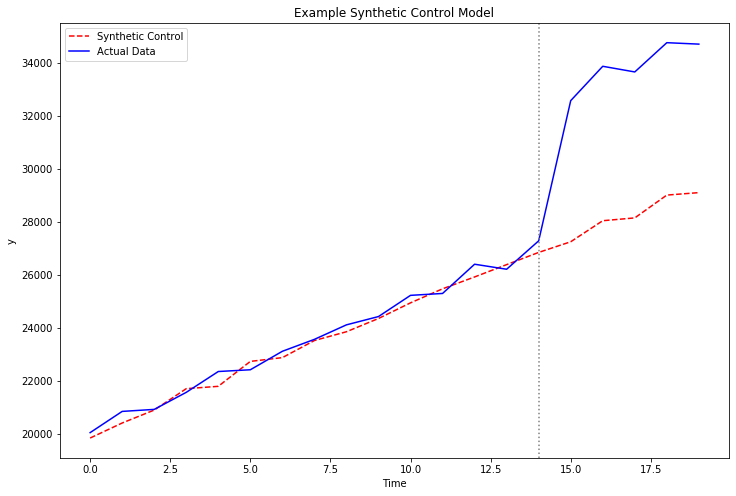

In [545]:
#Fit a SCM

solver = ControlSolver(data, "y", "ID", "Time", 15, "A", real_treatment_effect)
solver.preprocess_data()
solver.optimize()
print("Pre-treatment RMSPE:", solver.get_pre_treatment_rmspe())
print("Post-treatment RMSPE:", solver.get_post_treatment_rmspe())
solver.plot()

The dashed, gray, vertical line represents the last pre-treatment period. Every subsequent observation, the treated unit was exposed to the treatment.

# With Synthetic Difference-in-Differences

In [37]:
#Generate a dataset

#(self, n_donors, n_components, n_periods, treatment_period, treatment_effect)
data_generator = SimulateData(20, 5, 200, 180, 0.2)
data_generator.simulate_data(order=1)
data = data_generator.dataset
real_treatment_effect = data_generator.real_treatment_effect

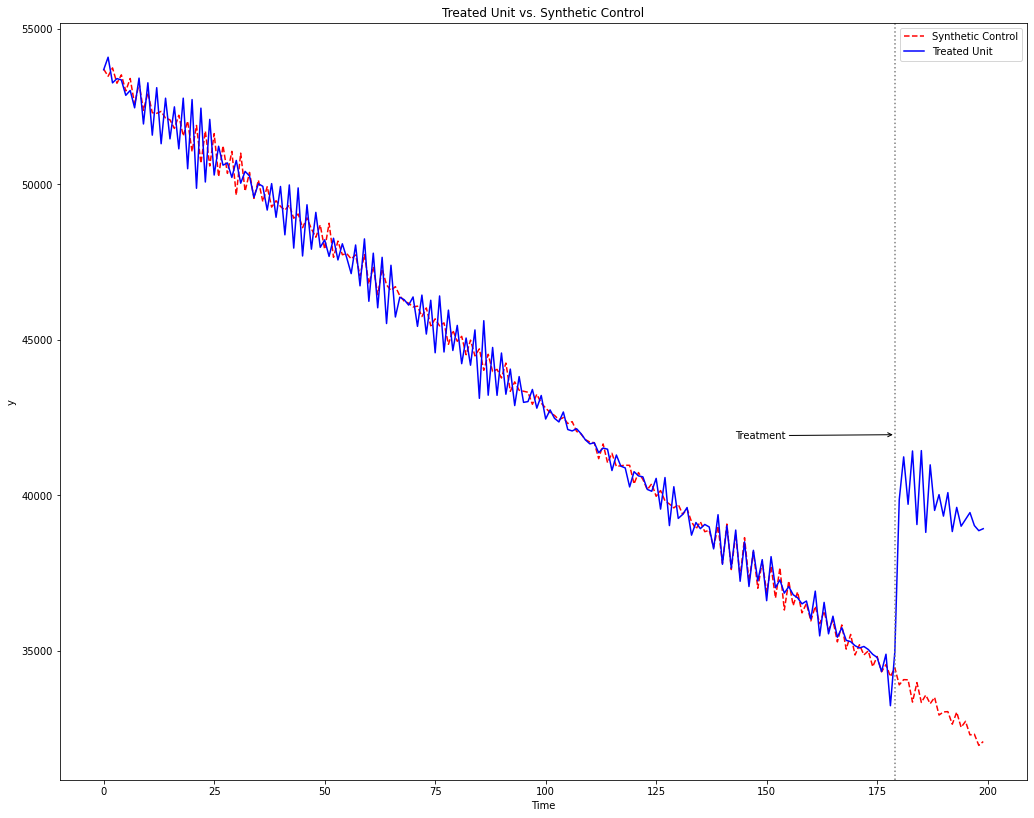

In [40]:
#Fit SCM to transformed data

synth = Synth(data, patag"y", "ID", "Time", 180, "A", n_optim=30)
synth.plot(["original"])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


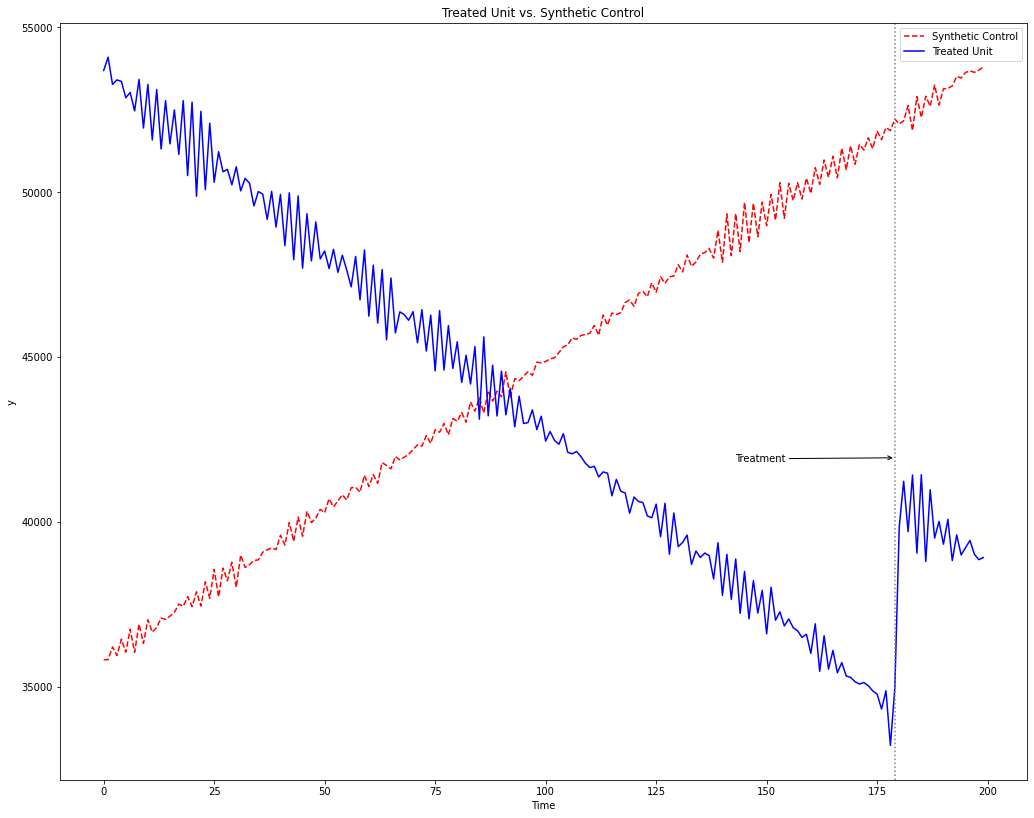

In [42]:
synth = DiffSynth(data, "y", "ID", "Time", 180, "A", n_optim=30)
synth.plot(["original"])

The dashed, gray, vertical line represents the last pre-treatment period. Every subsequent observation, the treated unit was exposed to the treatment.

# Comparing the models on post and pre-treatment RMSPE

# Datasets with outcomes that are linear in the covariates

In [38]:
#Make lists in which to store RMSPE results
scm_pre_order1 = []
scm_post_order1  = []

sdid_pre_order1  = []
sdid_post_order1  = []

steps = 500
failed_scm = np.zeros(steps)
failed_sdid = np.zeros(steps)

#failed_datasets = []

In [39]:
#Initalize data generator
#4 control units, 2 covariates, 20 periods (15-5 pre-post treatment split)
data_generator = SimulateData(4, 2, 15, 10, 0.2)

for step in range(int(len(scm_post_order1) + np.sum(failed_scm + failed_sdid)), steps):
    
    #Print progress
    if step % 10 == 0:
        print("{}%".format(step / 10))

    ###Simulate data - Same for both models for fair comparison##
    data_generator.simulate_data(order=1)
    data = data_generator.dataset
    real_treatment_effect = data_generator.real_treatment_effect

    ###Synthetic Difference-in-Differences###
    #Pre-process data for Synthetic Diff-in-Diff
    transformer = DataTransformer(data, "ID", "Time")
    transformer.mean_subtraction()
    transformed_data = transformer.transformed_data

    #Fit SCM to transformed data
    transformed_solver = ControlSolver(transformer.transformed_data, "y", "ID", "Time", 15, "A", real_treatment_effect)
    transformed_solver.preprocess_data()
    transformed_solver.optimize()

    #Compute Synthetic Control using W from transformed data on untransformed data
    solver = ControlSolver(data, "y", "ID", "Time", 10, "A", real_treatment_effect, transformed_solver.w)
    solver.preprocess_data()
    solver.add_constant() #Add the constant difference

    #Record SDID pre and post RMSPE
    try:
        solver.optimize()
        sdid_pre_order1.append(solver.get_pre_treatment_rmspe())
        sdid_post_order1.append(solver.get_post_treatment_rmspe())
    except:
        failed_sdid[step] = 1
        #failed_datasets.append(data)
        continue

    ###Repeat for Synthetic Control Model###
    #Fit Synthetic Control
    solver = ControlSolver(data, "y", "ID", "Time", 10, "A", real_treatment_effect)
    solver.preprocess_data()

    #Record SDID pre and post RMSPE
    try: #If one of the optimizers fail to converge
        solver.optimize()
        scm_pre_order1.append(solver.get_pre_treatment_rmspe())
        scm_post_order1.append(solver.get_post_treatment_rmspe())
    except:
        failed_scm[step] = 1
        #failed_datasets.append(data)

0.0%


/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:135: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%


## Summarizing results

In [102]:
scm_order1 = pd.DataFrame({"scm_pre":scm_pre_order1,
                          "scm_post": scm_post_order1})

sdid_order1 = pd.DataFrame({"sdid_pre":sdid_pre_order1,
                          "sdid_post": sdid_post_order1})


#Sometimes scm is really bad! But usually it is better
pd.concat([scm_order1.describe() , sdid_order1.describe()], axis=1)

,scm_pre,scm_post,sdid_pre,sdid_post
count,325.000000,325.000000,354.000000,354.000000
mean,937.818377,1884.325291,1032.072578,1606.703235
std,1094.646621,2554.916497,1196.342604,1517.180156
min,94.582647,73.763759,94.582647,86.724301
25%,301.191277,401.733065,304.258869,685.421933
50%,451.545852,721.684928,481.898190,1117.829272
75%,1185.834158,2585.045430,1393.505115,2037.563473
max,8167.948270,18521.998876,8201.111701,12015.284231


In [107]:
import statsmodels.stats.api as sms

#Confidence interval for mean RMSPE
print("Confidence interval mean of pre-treatment RMSPE for SCM:", sms.DescrStatsW(scm_order1["scm_pre"]).tconfint_mean())
print("Confidence interval mean of post-treatment RMSPE for SCM:", sms.DescrStatsW(scm_order1["scm_post"]).tconfint_mean())

print("Confidence interval mean of pre-treatment RMSPE for SDID:", sms.DescrStatsW(sdid_order1["sdid_pre"]).tconfint_mean())
print("Confidence interval mean of post-treatment RMSPE for SDID:", sms.DescrStatsW(sdid_order1["sdid_post"]).tconfint_mean())

Confidence interval mean of pre-treatment RMSPE for SCM: (818.36300841855, 1057.2737450716509)
Confidence interval mean of post-treatment RMSPE for SCM: (1605.5152301295084, 2163.1353521512424)
Confidence interval mean of pre-treatment RMSPE for SDID: (907.0197257010711, 1157.1254311840646)
Confidence interval mean of post-treatment RMSPE for SDID: (1448.113458124887, 1765.2930118648478)


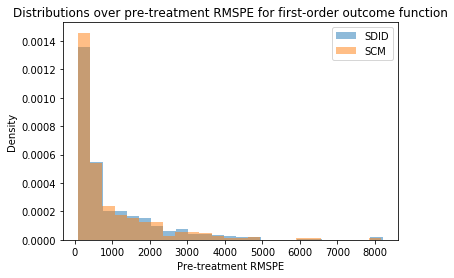

In [84]:
#Density=True to account for different sample sizes
plt.title("Distributions over pre-treatment RMSPE for first-order outcome function")
plt.hist(sdid_order1["sdid_pre"], bins=25, density=True, alpha=0.5, label = "SDID")
plt.hist(scm_order1["scm_pre"],bins=25, density=True, alpha=0.5, label = "SCM")
plt.legend(loc=0)
plt.ylabel("Density")
plt.xlabel("Pre-treatment RMSPE")
plt.show()

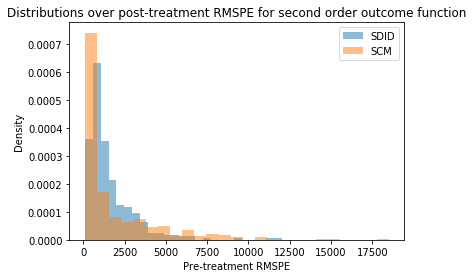

In [104]:
#Density=True to account for different sample sizes
plt.title("Distributions over post-treatment RMSPE for second order outcome function")
plt.hist(sdid_order1["sdid_post"], bins=25, density=True, alpha=0.5, label = "SDID")
plt.hist(scm_order1["scm_post"],bins=25, density=True, alpha=0.5, label = "SCM")
plt.legend(loc=0)
plt.ylabel("Density")
plt.xlabel("Pre-treatment RMSPE")
plt.show()

# Datasets where the outcome is a second-order function of the covariates

In [41]:
#Make lists in which to store RMSPE results
scm_pre_order2 = []
scm_post_order2  = []

sdid_pre_order2  = []
sdid_post_order2  = []

steps = 500
failed_scm_2 = np.zeros(steps)
failed_sdid_2 = np.zeros(steps)

In [43]:
#Initalize data generator
#4 control units, 2 covariates, 20 periods (15-5 pre-post treatment split)
data_generator = SimulateData(4, 2, 15, 10, 0.2)

for step in range(int(len(scm_post_order2) + np.sum(failed_scm_2 + failed_sdid_2)), steps):
    
    #Print progress
    if step % 10 == 0:
        print("{}%".format(step / 10))

    ###Simulate data - Same for both models for fair comparison##
    data_generator.simulate_data(order=2)
    data = data_generator.dataset
    real_treatment_effect = data_generator.real_treatment_effect

    ###Synthetic Difference-in-Differences###
    #Pre-process data for Synthetic Diff-in-Diff
    transformer = DataTransformer(data, "ID", "Time")
    transformer.mean_subtraction()
    transformed_data = transformer.transformed_data

    #Fit SCM to transformed data
    transformed_solver = ControlSolver(transformer.transformed_data, "y", "ID", "Time", 15, "A", real_treatment_effect)
    transformed_solver.preprocess_data()
    transformed_solver.optimize()

    #Compute Synthetic Control using W from transformed data on untransformed data
    solver = ControlSolver(data, "y", "ID", "Time", 10, "A", real_treatment_effect, transformed_solver.w)
    solver.preprocess_data()
    solver.add_constant() #Add the constant difference

    #Record SDID pre and post RMSPE
    try:
        solver.optimize()
        sdid_pre_order2.append(solver.get_pre_treatment_rmspe())
        sdid_post_order2.append(solver.get_post_treatment_rmspe())
    except:
        failed_sdid_2[step] = 1
        #failed_datasets.append(data)
        continue

    ###Repeat for Synthetic Control Model###
    #Fit Synthetic Control
    solver = ControlSolver(data, "y", "ID", "Time", 10, "A", real_treatment_effect)
    solver.preprocess_data()

    #Record SDID pre and post RMSPE
    try: #If one of the optimizers fail to converge
        solver.optimize()
        scm_pre_order2.append(solver.get_pre_treatment_rmspe())
        scm_post_order2.append(solver.get_post_treatment_rmspe())
    except:
        failed_scm_2[step] = 1
        #failed_datasets.append(data)

0.0%


/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:135: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%


## Summarizing results

In [103]:

scm_order2 = pd.DataFrame({"scm_pre":scm_pre_order2,
                          "scm_post": scm_post_order2})
sdid_order2 = pd.DataFrame({"sdid_pre":sdid_pre_order2,
                          "sdid_post": sdid_post_order2})

scm_order2.to_csv("scm_order2.csv", index=False)
sdid_order2.to_csv("sdid_order2.csv", index=False)

pd.concat([scm_order2.describe() , sdid_order2.describe()], axis=1)

,scm_pre,scm_post,sdid_pre,sdid_post
count,342.000000,342.000000,374.000000,374.000000
mean,791.208977,1559.147468,914.086710,1462.910642
std,930.354514,2141.170893,1079.622344,1311.239010
min,79.928440,84.666960,79.928405,138.606507
25%,284.833575,365.823335,289.545646,589.527625
50%,430.742181,686.304901,467.627085,1028.466443
75%,886.571328,1688.342241,1072.415114,1862.483861
max,6917.679682,14866.368259,6917.679682,8053.300503


In [106]:
#Confidence interval for mean RMSPE
print("Confidence interval mean of pre-treatment RMSPE for SCM:", sms.DescrStatsW(scm_order2["scm_pre"]).tconfint_mean())
print("Confidence interval mean of post-treatment RMSPE for SCM:", sms.DescrStatsW(scm_order2["scm_post"]).tconfint_mean())

print("Confidence interval mean of pre-treatment RMSPE for SDID:", sms.DescrStatsW(sdid_order2["sdid_pre"]).tconfint_mean())
print("Confidence interval mean of post-treatment RMSPE for SDID:", sms.DescrStatsW(sdid_order2["sdid_post"]).tconfint_mean())

Confidence interval mean of pre-treatment RMSPE for SCM: (692.2562740535247, 890.1616796093351)
Confidence interval mean of post-treatment RMSPE for SCM: (1331.4120796999553, 1786.8828571980341)
Confidence interval mean of pre-treatment RMSPE for SDID: (804.3136865536138, 1023.859733549382)
Confidence interval mean of post-treatment RMSPE for SDID: (1329.587474704207, 1596.233809693683)


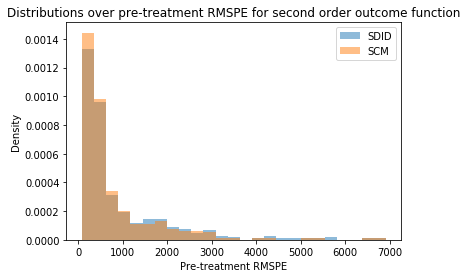

In [83]:
#Density=True to account for different sample sizes
plt.title("Distributions over pre-treatment RMSPE for second order outcome function")
plt.hist(sdid_order2["sdid_pre"], bins=25, density=True, alpha=0.5, label = "SDID")
plt.hist(scm_order2["scm_pre"],bins=25, density=True, alpha=0.5, label = "SCM")
plt.legend(loc=0)
plt.ylabel("Density")
plt.xlabel("Pre-treatment RMSPE")
plt.show()

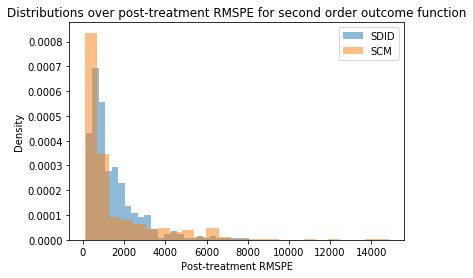

In [82]:
#Density=True to account for different sample sizes
plt.title("Distributions over post-treatment RMSPE for second order outcome function")
plt.hist(sdid_order2["sdid_post"], bins=25, density=True, alpha=0.5, label = "SDID")
plt.hist(scm_order2["scm_post"],bins=25, density=True, alpha=0.5, label = "SCM")
plt.legend(loc=0)
plt.ylabel("Density")
plt.xlabel("Post-treatment RMSPE")
plt.show()

# Reconstructing Fig.2 from Abadie, Diamond, Hainmueller 2015

Fig.2. Trends in per Capita GDP: West Germany versus Synthetic West Germany

Source: https://web.stanford.edu/~jhain/Paper/AJPS2015a.pdf?fbclid=IwAR1t38-sijOVIYUcpltDBs2gfTq2AV7Bw9xfDqv4saO2AGWMp8lla__3AOg'


This is mainly to show that the Synthetic Control implementation is not overly tailored to my synthetic data generation setup, but is directly compatible with any panel dataset that is structured like the industry standard.

In [10]:
data = pd.read_csv("/Users/oscarengelbrektson/Downloads/german_reunification.csv")
data = data.drop(columns="code", axis=1)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:135: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Pre-treatment RMSPE: 113.32929411025944


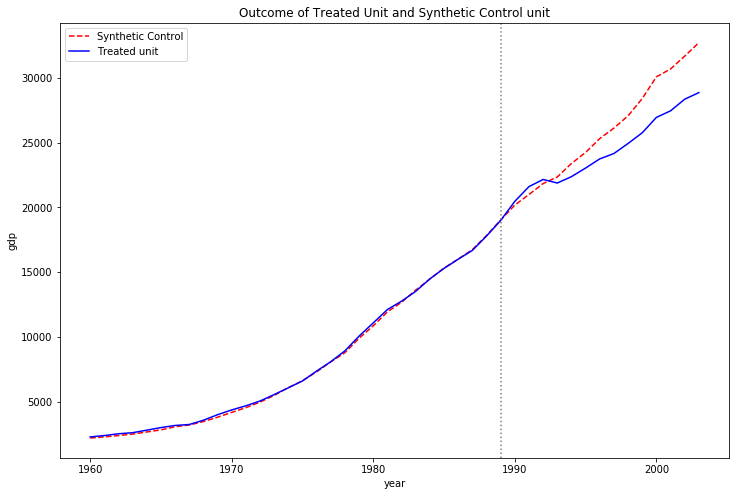

In [11]:
solver = ControlSolver(data, "gdp", "country", "year", 1990, "West Germany")
solver.preprocess_data()
solver.optimize()
print("Pre-treatment RMSPE:", solver.get_pre_treatment_rmspe())
solver.plot_outcome()

Disregard the legend and the title. This is supposed to be trends in per Capita GDP: West Germany versus Synthetic West Germany
